In [1]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from io import StringIO
import import_ipynb
from evaluation import to_timestamp, request_influxdb, query_data, histplots, boxplots, lineplots, missing_data, correlation


importing Jupyter notebook from evaluation.ipynb


In [2]:
# Load Tangaras
tangaras = pd.read_csv('../data/tangaras.csv')
tangaras.shape

(22, 6)

In [3]:
# Start Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#start_timestamp = to_timestamp('2023-03-17T00:00:00-05:00')
start_timestamp = to_timestamp('2023-04-03T00:00:00-05:00')
# End Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#end_timestamp = to_timestamp('2023-03-31T00:00:00-05:00')
end_timestamp = to_timestamp('2023-04-04T00:00:00-05:00')

print(f'Since: {start_timestamp} Until: {end_timestamp}')


Since: 1680498000000 Until: 1680584400000


In [4]:
# Get Data Frame Sensors
def df_sensors(tangaras, start_timestamp, end_timestamp):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    query = query_data(tangaras, start_timestamp, end_timestamp, datatype='tmp')
    # InfluxDB API REST Request
    influxdb_request = request_influxdb(query)
    #print(influxdb_request)
    #print(influxdb_request.text)

    # Data Frame InfluxDB Sensors
    df_influxdb_sensors = pd.read_csv(StringIO(influxdb_request.text), sep=",", low_memory=False)

    # Remove/Add Columns
    df_influxdb_sensors = df_influxdb_sensors[['time', 'name.1', 'last']]
    df_influxdb_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'TEMP'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_sensors.loc[df_influxdb_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'TEMP']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'TEMP': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    # Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())
    df_sensors['DATETIME'] = pd.to_datetime(df_sensors['DATETIME'])

    # Set Index
    df_sensors.set_index('DATETIME', inplace=True)
    df_sensors = df_sensors.asfreq(freq='30S')

    df_sensors[df_sensors.columns.to_list()] = df_sensors[df_sensors.columns.to_list()].astype('float64')
    
    return df_sensors


In [5]:
# Data Frame Sensors
temp_raw = df_sensors(tangaras, start_timestamp, end_timestamp)
temp_raw.head()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
DATETIME,,,,,,,,,,,,,,,,,,,,,
2023-04-03 00:00:00-05:00,0.0,20.63,21.90,21.87,22.87,21.42,22.87,NaN,NaN,NaN,...,27.08,26.45,NaN,26.47,NaN,22.17,21.16,NaN,26.23,NaN
2023-04-03 00:00:30-05:00,0.0,20.61,NaN,21.86,22.91,21.39,22.88,26.44,29.32,26.85,...,27.06,26.43,28.37,26.47,25.48,NaN,NaN,26.4,26.23,26.70
2023-04-03 00:01:00-05:00,0.0,20.60,21.86,21.86,NaN,21.42,22.88,26.39,29.32,26.81,...,27.05,26.40,28.33,26.47,25.38,22.17,21.19,26.4,26.25,26.68
2023-04-03 00:01:30-05:00,0.0,20.58,21.84,21.87,22.88,21.42,22.87,26.44,29.30,26.78,...,27.05,26.41,28.28,26.46,25.41,22.17,21.16,26.4,26.26,26.76
2023-04-03 00:02:00-05:00,0.0,20.55,21.86,21.86,22.87,21.42,22.87,26.45,29.29,26.74,...,27.05,26.40,28.24,26.47,25.47,22.18,21.18,26.4,26.25,26.80


# Descriptive Statistics

In [6]:
# Describe Data
temp_raw.describe()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,2763.0,2676.000000,2652.000000,2670.000000,2662.000000,2671.000000,2660.000000,2748.000000,2699.000000,2268.000000,...,2715.000000,2650.000000,2742.000000,2758.000000,2695.000000,2677.000000,2674.000000,2735.000000,2734.000000,2728.000000
mean,0.0,26.958928,25.706712,27.993697,26.390872,26.835957,27.631380,29.547205,31.486376,31.187650,...,31.224357,28.185442,31.410336,30.514547,30.532742,28.208102,27.313657,30.217879,29.695618,30.656994
std,0.0,5.105682,3.150129,4.995250,2.962249,4.724823,4.190509,3.280467,2.618469,4.972858,...,4.264028,2.332961,2.762924,3.809778,5.371827,4.731224,4.939929,4.046528,3.288395,3.477118
min,0.0,20.380000,21.410000,21.390000,22.400000,20.950000,22.460000,25.020000,28.300000,25.720000,...,25.450000,25.370000,27.890000,25.820000,23.980000,22.020000,20.780000,25.000000,25.300000,25.890000
25%,0.0,21.140000,22.100000,22.120000,23.080000,21.660000,23.100000,26.390000,28.780000,26.360000,...,26.450000,25.900000,28.740000,26.400000,24.930000,22.770000,21.580000,26.100000,26.020000,26.930000
50%,0.0,26.940000,25.850000,28.310000,26.800000,26.370000,27.090000,29.080000,31.770000,29.500000,...,30.880000,28.150000,30.910000,29.840000,29.700000,28.510000,27.695000,30.000000,29.590000,30.390000
75%,0.0,31.000000,28.610000,32.240000,28.940000,30.360000,31.105000,32.180000,33.770000,36.227500,...,35.850000,29.515000,33.107500,33.870000,34.670000,31.900000,31.210000,33.600000,32.580000,33.757500
max,0.0,35.850000,30.570000,36.240000,31.160000,35.450000,35.020000,36.540000,36.210000,42.440000,...,37.850000,35.850000,38.240000,38.240000,42.170000,36.290000,35.430000,38.200000,35.280000,36.590000


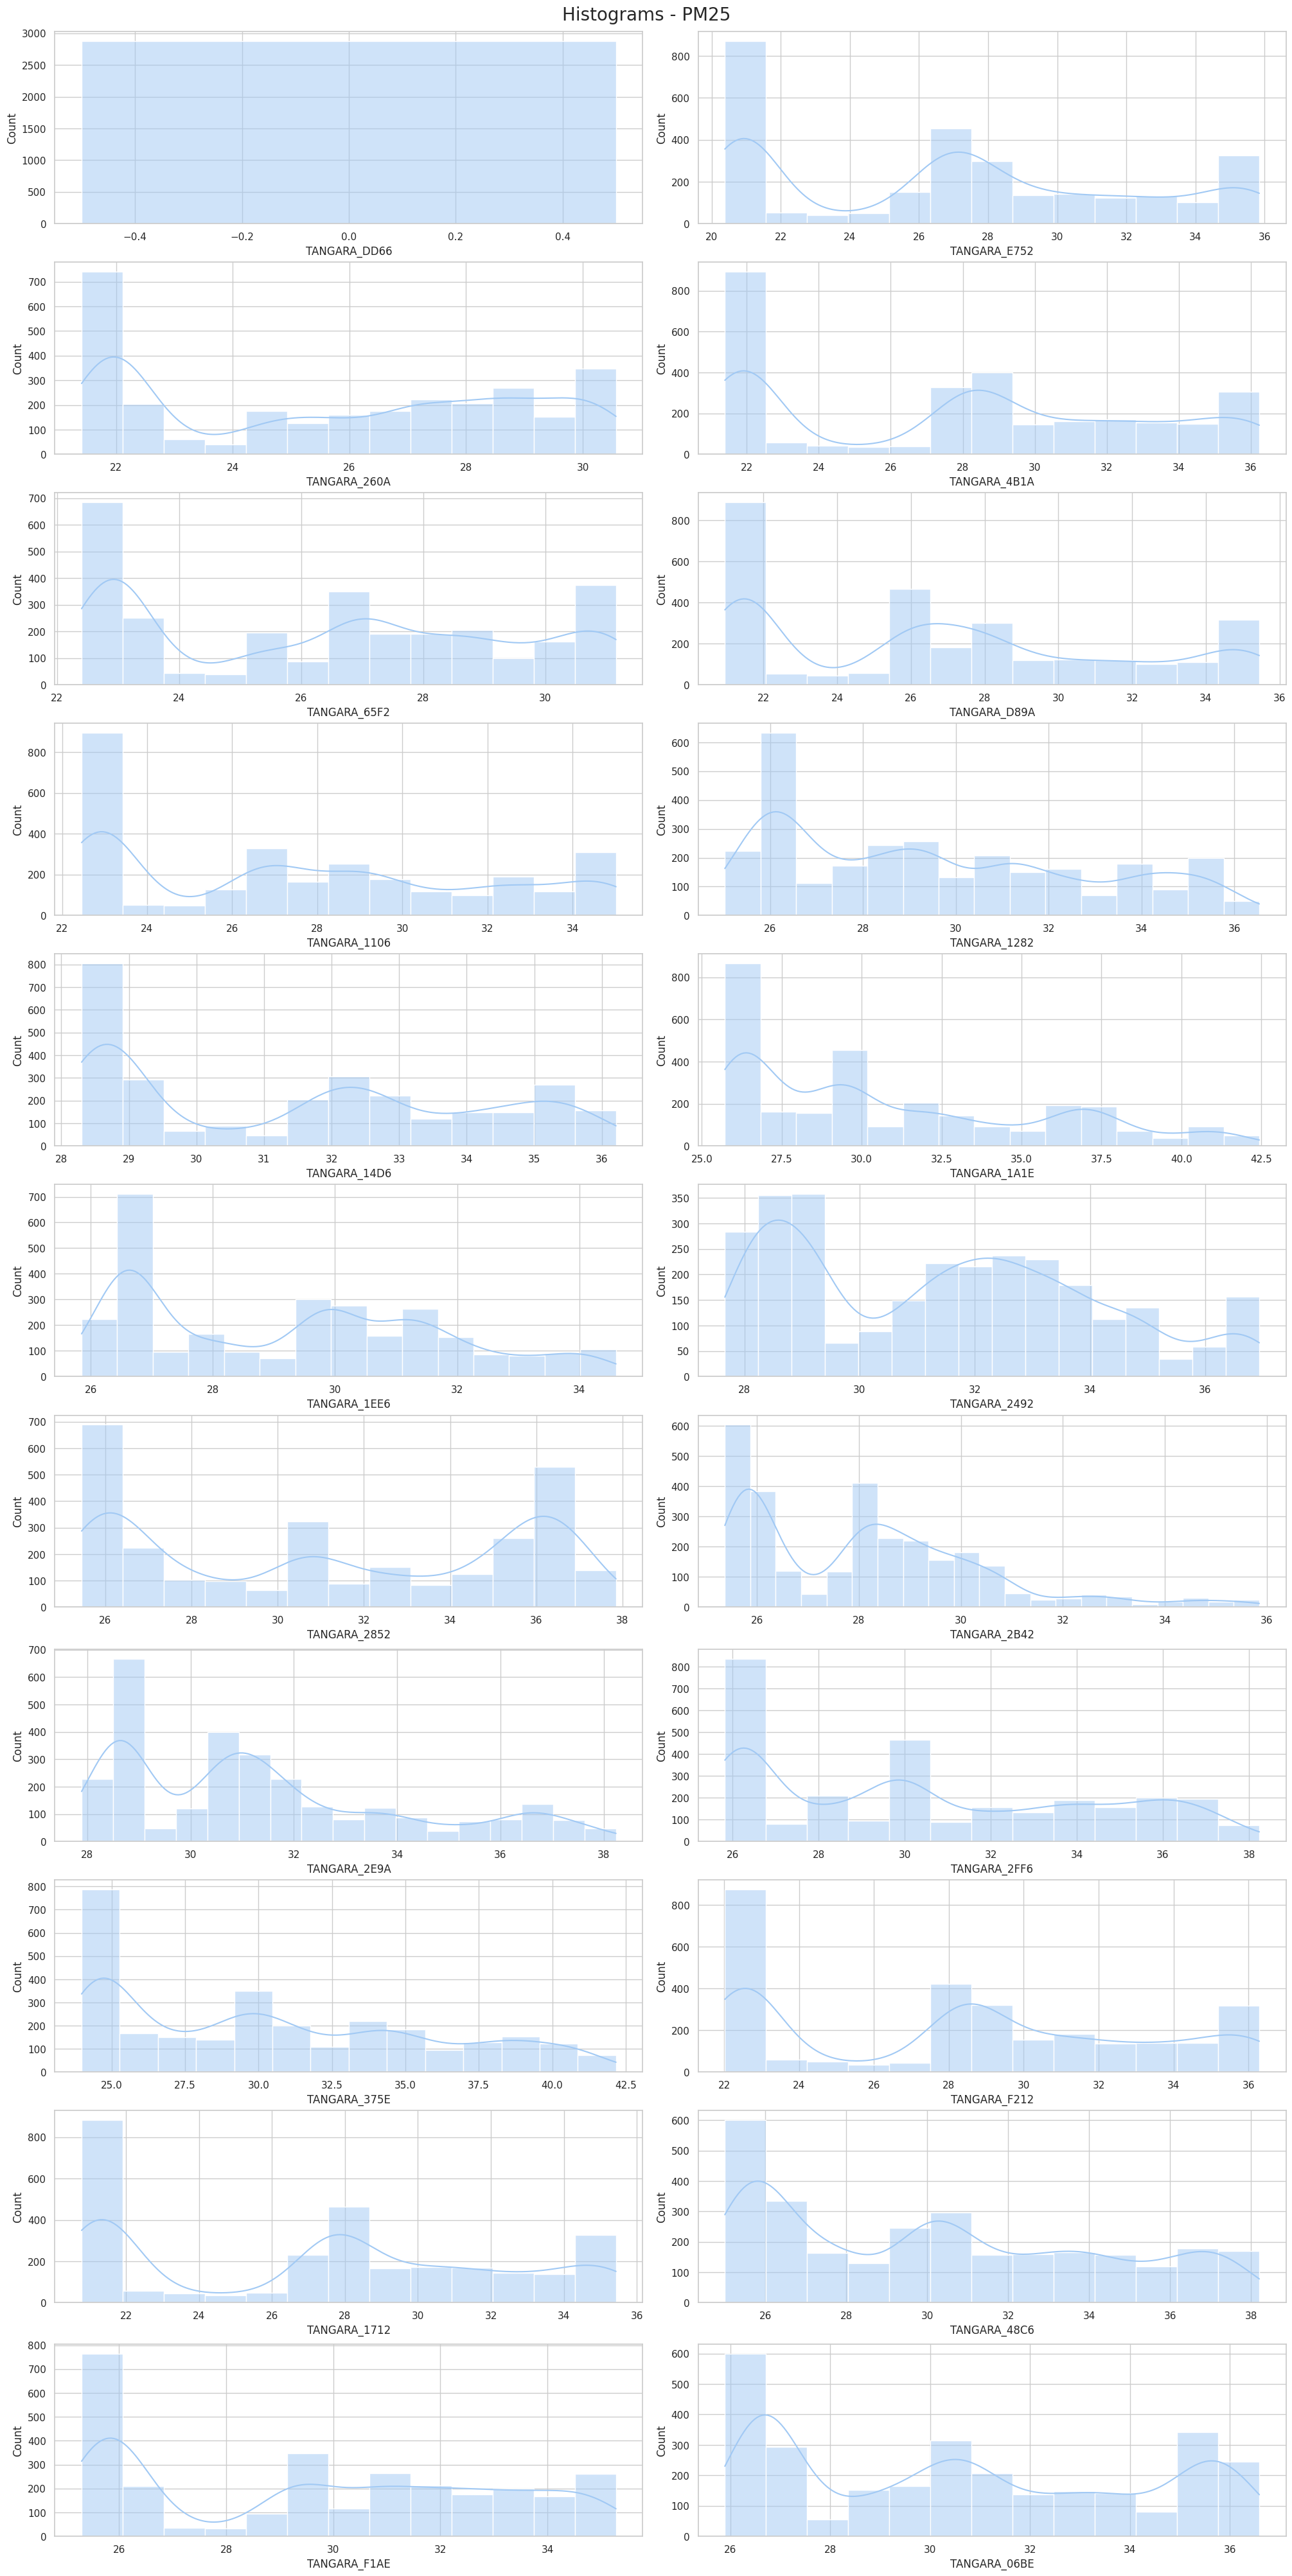

In [7]:
# Plot Temperature Histograms
histplots(temp_raw)

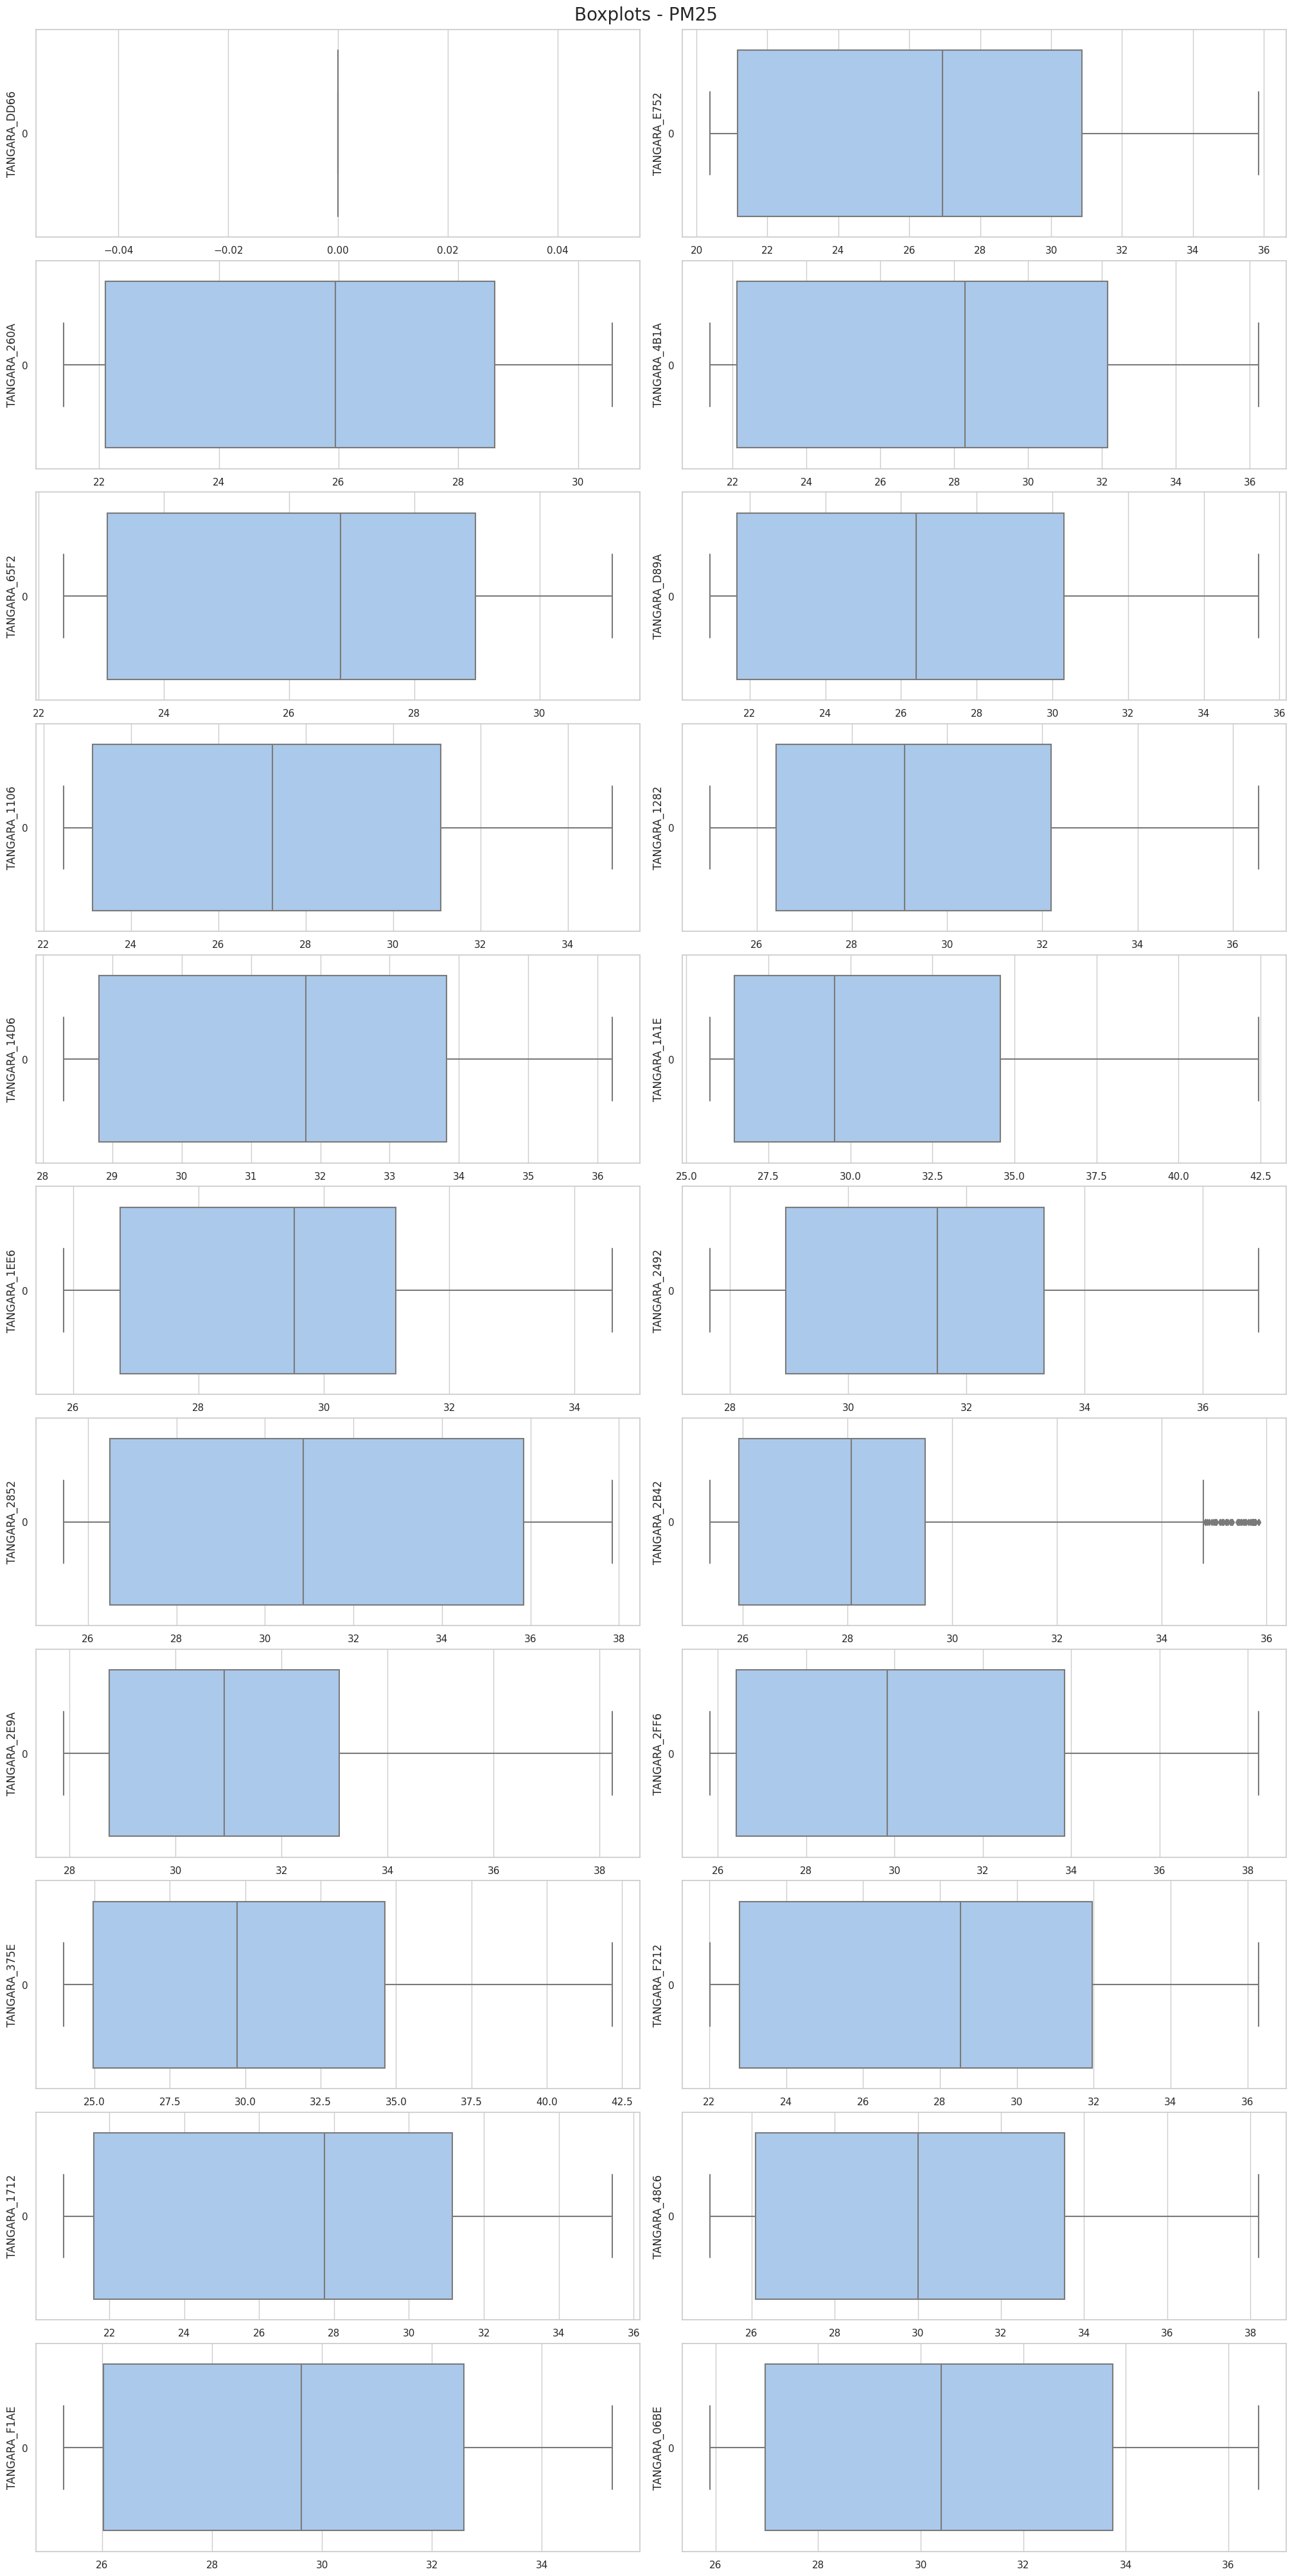

In [8]:
# Plot Temperature Boxplots
boxplots(temp_raw)

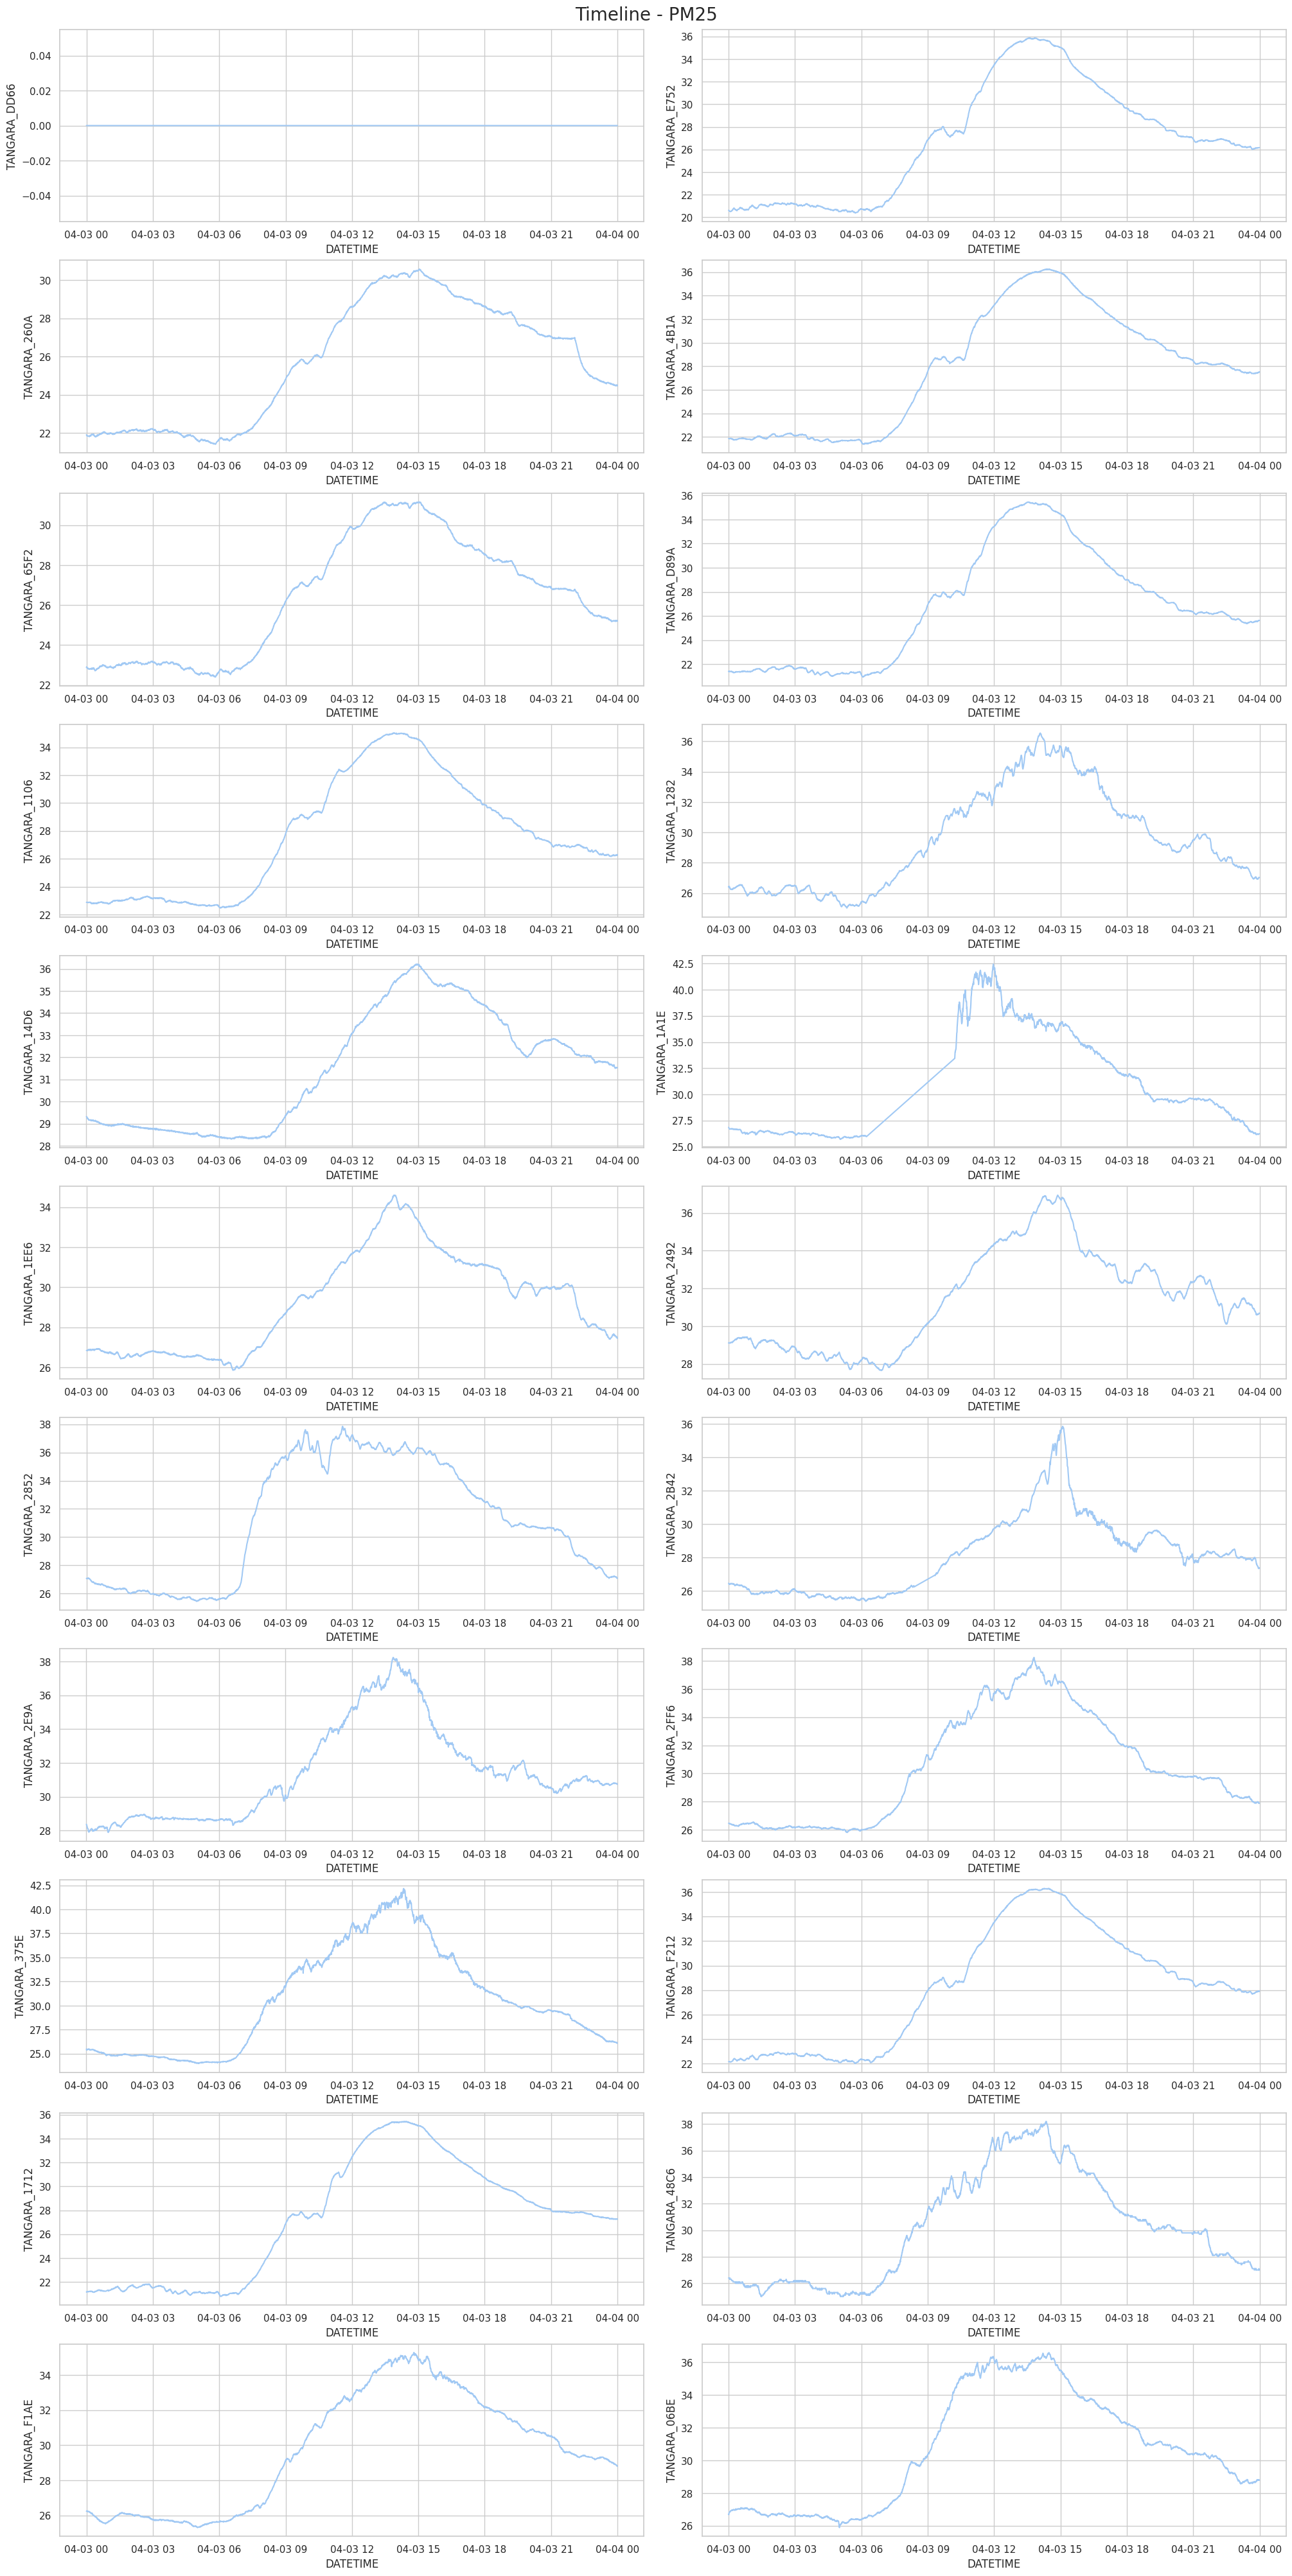

In [9]:
# Plot Temperature Lineplots
lineplots(temp_raw)

In [10]:
# Missing Data Sensors
threshold = 85
to_be_checked = missing_data(temp_raw, threshold)

print(f'Threshold: {threshold}%')
print(f'Total Sensors: {len(temp_raw.columns)}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked

Threshold: 85%
Total Sensors: 22
To Be Checked: 1


[{'ID': 'TANGARA_1A1E', 'Data': '79%', 'Missing': '21%'}]

In [11]:
# Sensors to evaluate by Pearson correlation coefficient
sensors_to_evaluate = temp_raw[['TANGARA_DD66', 'TANGARA_E752', 'TANGARA_4B1A', 'TANGARA_D89A', 'TANGARA_1106', 'TANGARA_F212', 'TANGARA_1712']]

# Pearson correlation coefficient
threshold = 0.7
to_be_checked = correlation(sensors_to_evaluate, 'TANGARA_D89A', threshold)

# Correlation Sensors
print(f'Threshold: {threshold}')
print(f'Total Sensors: {len(sensors_to_evaluate.columns)}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked


Threshold: 0.7
Total Sensors: 7
To Be Checked: 1


[{'Reference': {'ID': 'TANGARA_D89A', 'Data': 2880, 'Freq': <30 * Seconds>},
  'Target': {'ID': 'TANGARA_DD66', 'Data': 2880, 'Freq': <30 * Seconds>},
  'Correlation': 0}]

In [ ]:
# Save Temperature raw data into CSV file
temp_raw.to_csv('../data/temp_raw.csv')